# Simulations

In [1]:
### Import Packages ###
import os
import numpy as np
import pandas as pd
import math as math
import random as random
from scipy import stats
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split


### Local Packages ###
from utils.Prediction import *
from utils.Selector import *
from utils.Auxiliary import *
from utils.Main import *

# Input

In [2]:
### Input ###
DataFile = "MONK3"
rashomon_bound_adder = .4
regularization = 0.1
TestProportion = 0.2

# Train TreeFarms

In [3]:
### Load Data ###
df = LoadData(DataFile)

### Train/Test split ###
X_Train, X_Test, y_Train, y_Test = train_test_split(df.loc[:, df.columns != "Y"], df["Y"], test_size=TestProportion)
df_Train = X_Train.copy()
df_Train.insert(0, 'Y', y_Train)
df_Test = X_Test.copy()
df_Test.insert(0, 'Y', y_Test)

In [4]:
## Train TreeFarms Model ###
config = {"regularization": regularization, "rashomon_bound_adder": rashomon_bound_adder}
TreeFarmsModel = TREEFARMS(config)
TreeFarmsModel.fit(df_Train.loc[:, df_Train.columns != "Y"], df_Train["Y"])
TreeCount = TreeFarmsModel.get_tree_count()

null
treefarms reported successful execution
Finding Optimal Objective...
{
  "false": {
    "false": {
      "complexity": 0.10000000149011612,
      "loss": 0.020618556067347527,
      "name": "Y",
      "prediction": 0
    },
    "feature": 2,
    "name": "a2_1",
    "reference": 1,
    "relation": "==",
    "true": {
      "complexity": 0.10000000149011612,
      "loss": 0.11340206116437912,
      "name": "Y",
      "prediction": 1
    },
    "type": "integral"
  },
  "feature": 3,
  "model_objective": 0.495876282453537,
  "name": "a2_2",
  "reference": 1,
  "relation": "==",
  "true": {
    "complexity": 0.10000000149011612,
    "loss": 0.06185566633939743,
    "name": "Y",
    "prediction": 1
  },
  "type": "integral"
}
{
  "false": {
    "false": {
      "complexity": 0.10000000149011612,
      "loss": 0.020618556067347527,
      "name": "Y",
      "prediction": 0
    },
    "feature": 3,
    "name": "a2_2",
    "reference": 1,
    "relation": "==",
    "true": {
      "complexi

In [5]:
TreeCount

78264

# Training Loss

In [6]:
### Duplicate and Unique ###
PredictionArray_Duplicate = pd.DataFrame(np.array([TreeFarmsModel[i].predict(df_Train.loc[:, df_Train.columns != "Y"]) for i in range(TreeCount)]))
PredictionArray_Unique = pd.DataFrame(PredictionArray_Duplicate).drop_duplicates(keep='first', ignore_index=False)
TrueValues = df_Train["Y"].to_numpy()

### Set ###
PredictionArray = PredictionArray_Unique

### Tree Classification Errors ###
TreeClassificationErrors = PredictionArray.ne(TrueValues, axis=1).mean(axis=1)
BestAccuracy = float(np.max(TreeClassificationErrors))

### Threshold Values ###
EpsilonVec = BestAccuracy - TreeClassificationErrors
MinEpsilon = float(np.min(EpsilonVec))
MaxEpsilon = float(np.max(EpsilonVec))

### Threshold of Training Data ###
ThresholdIndices = []
for i in range(int(MinEpsilon*100),int(MaxEpsilon*100)):

    # Determine Threshold #
    Threshold = i/100

    # Get models where
    EpsilonVecIndices = np.where(np.array(EpsilonVec) <= Threshold)[0].tolist()
    ModelIndices = list(PredictionArray.iloc[EpsilonVecIndices].index)
    ThresholdIndices.append(ModelIndices)

# Test Error

In [7]:
### Set Up ###
Epsilon_F1Score = []
Epsilon_ClassError = []

### Get Test Error ###
for ThresholdList in ThresholdIndices:

    ## Get Each Tree's Prediction ##
    Test_Prediction = pd.DataFrame(np.array([TreeFarmsModel[j].predict(df_Test.loc[:, df_Test.columns != "Y"]) for j in ThresholdList]))
    Test_Prediction.columns = df_Test.index.astype(str)

    ## Get Ensemble Prediction ##
    EnsemblePrediction = pd.Series(stats.mode(Test_Prediction)[0])
    EnsemblePrediction.index = df_Test["Y"].index

    ## Get Error Mettrics ##
    F1Score = float(f1_score(df_Test["Y"], EnsemblePrediction, average='micro'))
    ClassError = float(np.mean(EnsemblePrediction ==  df_Test["Y"]))

    ## Append ##
    Epsilon_F1Score.append(F1Score)
    Epsilon_ClassError.append(ClassError)


# Plot

## Model Length

In [8]:
ModelLengths = []
for i in range(len(ThresholdIndices)):
    ModelLengths.append(len(ThresholdIndices[i]))


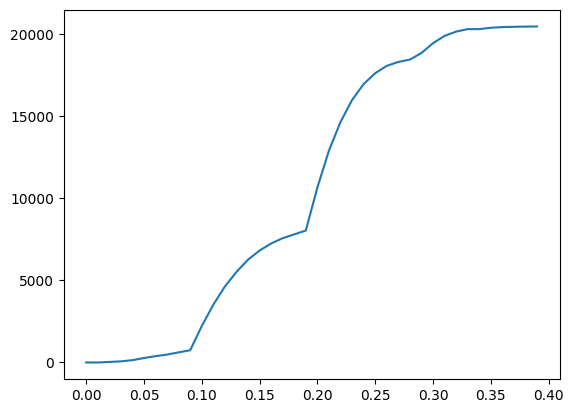

In [9]:
plt.plot(np.arange(int(MinEpsilon*100),int(MaxEpsilon*100))/100,ModelLengths)


# Error by Rashomon Threshold

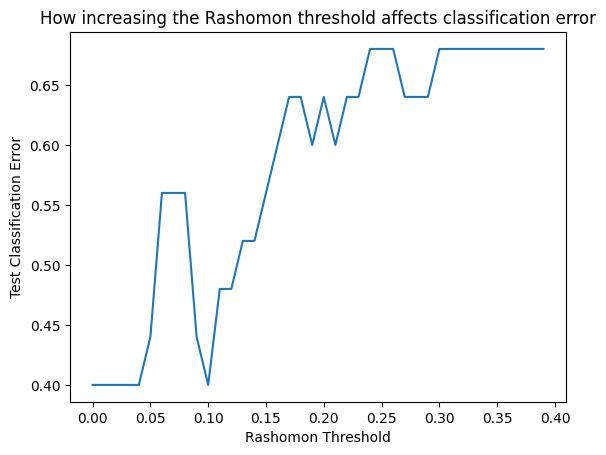

In [10]:
plt.plot(np.arange(int(MinEpsilon*100),int(MaxEpsilon*100))/100,Epsilon_ClassError)
plt.xlabel("Rashomon Threshold")
plt.ylabel("Test Classification Error")
plt.title("How increasing the Rashomon threshold affects classification error")
plt.show()